In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.interpolate import interp1d
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


In [2]:
df1 = pd.read_csv("data/group1.csv")
#add a column to df1 with the value 1   
df1["group"] = 1
df2 = pd.read_csv("data/group2_filtered.csv")
#add a column to df2 with the value 2
df2["group"] = 2
#concatenate the two dataframes
df = pd.concat([df1, df2], ignore_index=True)
#sort the dataframe by the task number
df = df.sort_values(by="task number")
#reset the index
df = df.reset_index(drop=True)
#get fst  value and add it in the right task number 
fst = pd.read_csv("data/fst.csv")
# Merge on 'task number'
df = pd.merge(df, fst, on="task number", how="left")
#print the dataframe
df.head(10)

,name,task number,estimation 1,estimation 2,group,fst
0,Pierre-Francois,Task 1,30.0,28.0,1,7
1,Jessica,Task 1,28.0,29.0,1,7
2,Adam,Task 1,35.0,28.0,1,7
3,Asher,Task 1,27.0,28.0,1,7
4,Omer,Task 1,25.5,25.5,2,7
5,Uttara,Task 1,NaN,30.0,2,7
6,Kamile,Task 1,25.0,25.5,2,7
7,Pierre-Francois,Task 2,55.0,45.0,1,42
8,Jessica,Task 2,40.0,41.0,1,42
9,Adam,Task 2,35.0,35.0,1,42


In [3]:
avg_by_task = df.groupby("task number")["estimation 2"].mean()
print(avg_by_task)

task number
Task 1    27.714286
Task 2    35.571429
Task 3    35.400000
Task 4    48.200000
Task 5    58.200000
Name: estimation 2, dtype: float64


C:\Users\papad\AppData\Local\Temp\ipykernel_20036\3629882899.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.lineplot(


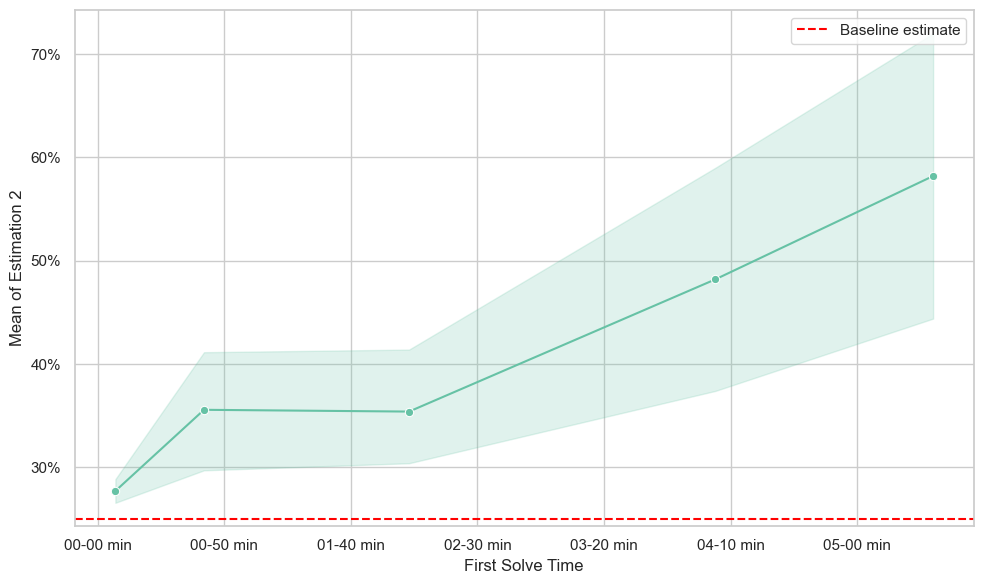

In [4]:
# ----------------------------------------------------------------
# 2) Group & aggregate (so each fst has mean of estimation 2)
#    Or directly let seaborn compute the mean. 
#    But if you want to "flatten" first:
# ----------------------------------------------------------------
grouped_df = df.groupby("fst", as_index=False)["estimation 2"].mean()

# ----------------------------------------------------------------
# 3) Convert fst (minutes) to hh-mm format
# ----------------------------------------------------------------
def minutes_to_hhmm(minutes):
    hours = minutes // 60
    mins = minutes % 60
    return f"{hours:02d}-{mins:02d} min"  # e.g. "05-30 min"

grouped_df["fst_hhmm"] = grouped_df["fst"].apply(minutes_to_hhmm)

# ----------------------------------------------------------------
# 4) Plot using seaborn lineplot with 95% CI shading
# ----------------------------------------------------------------
sns.set_theme(style="whitegrid", palette="Set2")

plt.figure(figsize=(10, 6))

# In seaborn >= 0.12, you can do:
#   sns.lineplot(data=df, x="fst", y="estimation 2", ci=95)
# and it will automatically show the CI as a shaded region.

# But if you want the aggregated mean with shading, pass the original df, 
# let seaborn do the grouping, and use "estimator='mean'" plus "ci=95".
ax = sns.lineplot(
    data=df,
    x="fst", 
    y="estimation 2",
    estimator="mean",
    ci=95,        # 95% Confidence Interval
    marker="o"
)

# ----------------------------------------------------------------
# 5) Customize the x-axis to show hh-mm format
# ----------------------------------------------------------------
# We'll replace the numeric x-ticks with the custom hh-mm format:
def format_xaxis(x, pos):
    # x is the "fst" in minutes.  Convert to int for safety, in case of float:
    x_int = int(round(x))
    hours = x_int // 60
    mins = x_int % 60
    return f"{hours:02d}-{mins:02d} min"

ax.set_xlabel("First Solve Time")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_xaxis))

# ----------------------------------------------------------------
# 6) Convert y-axis to show "%" symbol
# ----------------------------------------------------------------
def format_yaxis(x, pos):
    return f"{x:.0f}%"

ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_yaxis))
ax.set_ylabel("Mean of Estimation 2")

# ----------------------------------------------------------------
# 7) Draw a horizontal line at 25%
# ----------------------------------------------------------------
plt.axhline(25, color="red", linestyle="--", label="Baseline estimate")

# Show legend (this will also show the line label)
plt.legend()

# Tight layout for prettiness
plt.tight_layout()

plt.show()

In [5]:
# First, group by FST and compute the mean of "estimation 2"
avg_df = df.groupby("fst")["estimation 2"].mean().reset_index()

# Sort by FST just to be safe
avg_df = avg_df.sort_values("fst").reset_index(drop=True)

# Extract the x and y arrays for interpolation
x = avg_df["fst"].values
y = avg_df["estimation 2"].values

#confidence interval of y
y_ci = df.groupby("fst")["estimation 2"].std().reset_index()
y_ci = y_ci["estimation 2"].values

print(x)
print(y)
print(y_ci)

# Create interpolation functions for different methods
f_linear   = interp1d(x, y, kind="linear")
f_nearest  = interp1d(x, y, kind="nearest")
f_quad     = interp1d(x, y, kind="quadratic")  # "quadratic" piecewise polynomial
f_cubic    = interp1d(x, y, kind="cubic")      # "cubic" piecewise polynomial

# Create a new x-grid for plotting the smooth interpolation
x_new = np.linspace(x.min(), x.max(), 200)  # 200 points between min & max

[  7  42 123 244 330]
[27.71428571 35.57142857 35.4        48.2        58.2       ]
[ 1.67971086  8.12110713  6.76756973 14.02497772 18.55262785]


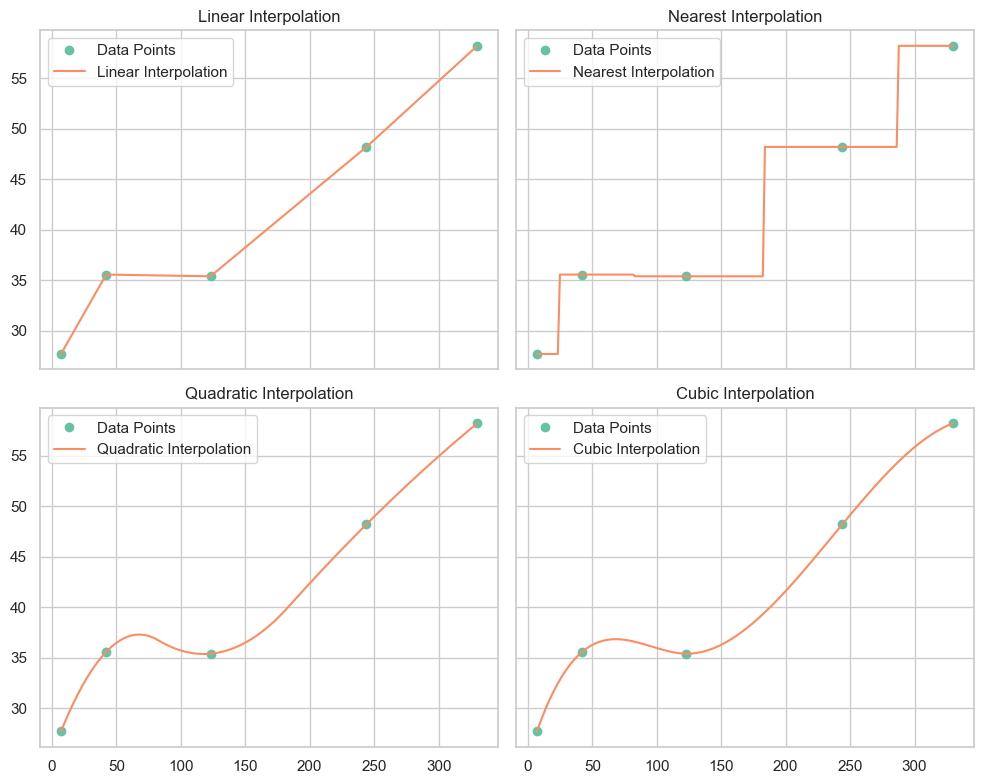

In [6]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

# ---------------
# 1) Linear
# ---------------
axes[0, 0].plot(x, y, "o", label="Data Points")  # original points
axes[0, 0].plot(x_new, f_linear(x_new), "-", label="Linear Interpolation")
axes[0, 0].set_title("Linear Interpolation")
axes[0, 0].legend()

# ---------------
# 2) Nearest
# ---------------
axes[0, 1].plot(x, y, "o", label="Data Points")
axes[0, 1].plot(x_new, f_nearest(x_new), "-", label="Nearest Interpolation")
axes[0, 1].set_title("Nearest Interpolation")
axes[0, 1].legend()

# ---------------
# 3) Quadratic
# ---------------
axes[1, 0].plot(x, y, "o", label="Data Points")
axes[1, 0].plot(x_new, f_quad(x_new), "-", label="Quadratic Interpolation")
axes[1, 0].set_title("Quadratic Interpolation")
axes[1, 0].legend()

# ---------------
# 4) Cubic
# ---------------
axes[1, 1].plot(x, y, "o", label="Data Points")
axes[1, 1].plot(x_new, f_cubic(x_new), "-", label="Cubic Interpolation")
axes[1, 1].set_title("Cubic Interpolation")
axes[1, 1].legend()

# Adjust spacing and show
plt.tight_layout()
plt.show()

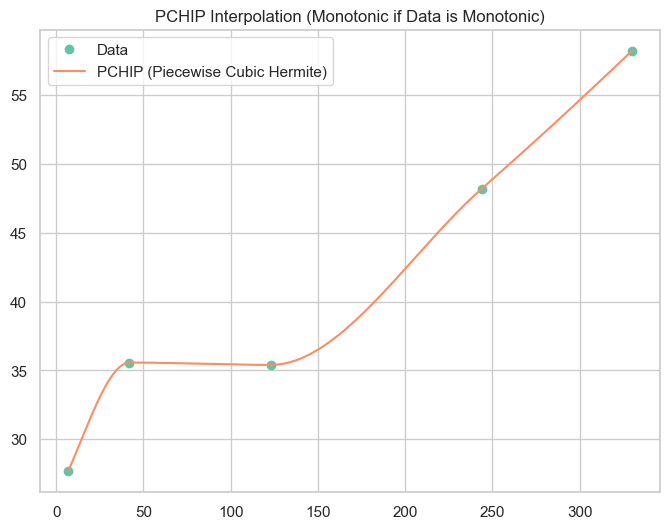

In [7]:
from scipy.interpolate import PchipInterpolator

# Your data
x = np.array([7, 42, 123, 244, 330])
y = np.array([27.71428571, 35.57142857, 35.4, 48.2, 58.2])

# Create a monotonic PCHIP interpolator (works if y is monotonic or nearly)
f_pchip = PchipInterpolator(x, y)

# Fine grid for plotting
x_new = np.linspace(x.min(), x.max(), 200)
y_pchip = f_pchip(x_new)

plt.figure(figsize=(8,6))
plt.plot(x, y, 'o', label='Data')
plt.plot(x_new, y_pchip, '-', label='PCHIP (Piecewise Cubic Hermite)')
plt.title("PCHIP Interpolation (Monotonic if Data is Monotonic)")
plt.legend()
plt.show()

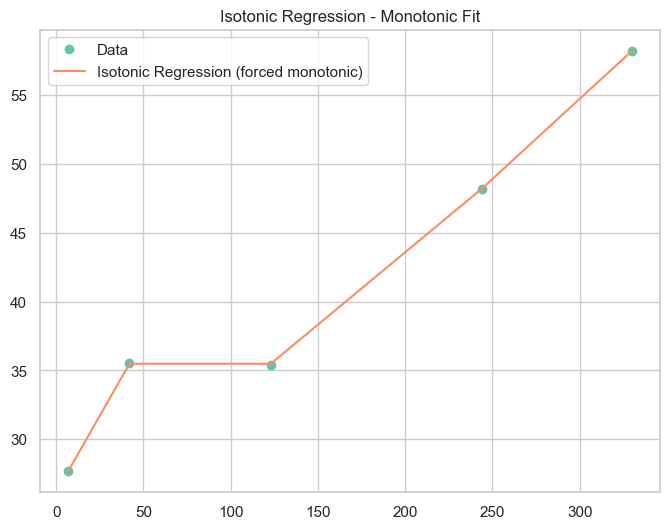

In [8]:
from sklearn.isotonic import IsotonicRegression

x = np.array([7, 42, 123, 244, 330])
y = np.array([27.71428571, 35.57142857, 35.4, 48.2, 58.2])

# Initialize and fit
iso_reg = IsotonicRegression(increasing=True)
iso_reg.fit(x, y)
# Predict on a new grid
x_new = np.linspace(x.min(), x.max(), 200)
y_iso = iso_reg.predict(x_new)

plt.figure(figsize=(8,6))
plt.plot(x, y, 'o', label='Data')
plt.plot(x_new, y_iso, '-', label='Isotonic Regression (forced monotonic)')
plt.title("Isotonic Regression - Monotonic Fit")
plt.legend()
plt.show()

- We used Bayesian inference with a monotonic constraint by parameterizing 𝑓 f as cumulative sums of nonnegative increments.
- Each observed 
(
𝑥
𝑖
,
𝑦
𝑖
)
 enters the likelihood with a varying standard deviation (derived from the confidence interval).
- The resulting posterior distribution of 
𝑓 respects monotonicity, while weighting points with smaller CI more strongly.
- You can extend this idea to piecewise linear segments (if you want continuity between data points) or even a fully continuous monotonic spline. However, the core principle is always the same: nondecreasing increments + weighted likelihood for each data point.

In [19]:


# ---------------------------------
# 1) Prepare data
# ---------------------------------
x = np.array([0, 7, 42, 123, 244, 330]) #cybench fst
y = np.array([25, 27.71, 35.57, 35.4, 48.2, 58.2])
ci = np.array([0.01, 1.68, 8.12, 6.77, 14.02, 18.55])  # half-width of 95% CI or similar

# For simplicity, let's approximate the standard deviation for each point.
# If ci is half-width of a 95% CI, then roughly:
#    95% CI = mean ± 1.96*sigma
# => half-width ~ 1.96*sigma
# => sigma ~ half-width / 1.96
sigma = ci / 1.96

# Ensure x is sorted. (It already is in this example.)
# If it weren't sorted, we'd sort x,y,sigma together.

# ---------------------------------
# 2) Define a PyMC model
# ---------------------------------
with pm.Model() as monotonic_model:
    # Intercept: f(x_0)
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    
    # We have (n-1) increments for n points. Each increment >= 0 (HalfNormal ensures positivity).
    increments = pm.HalfNormal("increments", sigma=10, shape=len(x)-1)
    
    # f_vals[i] = intercept + sum(increments[:i])
    # so f(x_0) = intercept
    #    f(x_1) = intercept + increments[0]
    #    f(x_2) = intercept + increments[0] + increments[1]
    # ... and so on ...
    f_vals = pm.Deterministic(
        "f_vals",
        intercept + pm.math.cumsum(pm.math.concatenate([[0], increments]))
    )
    
    # Likelihood: each observed y_i ~ Normal(f_vals[i], sigma[i])
    pm.Normal("obs", mu=f_vals, sigma=sigma, observed=y)
    
    # ---------------------------------
    # 3) Sample from the posterior
    # ---------------------------------
    trace = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, increments]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 156 seconds.


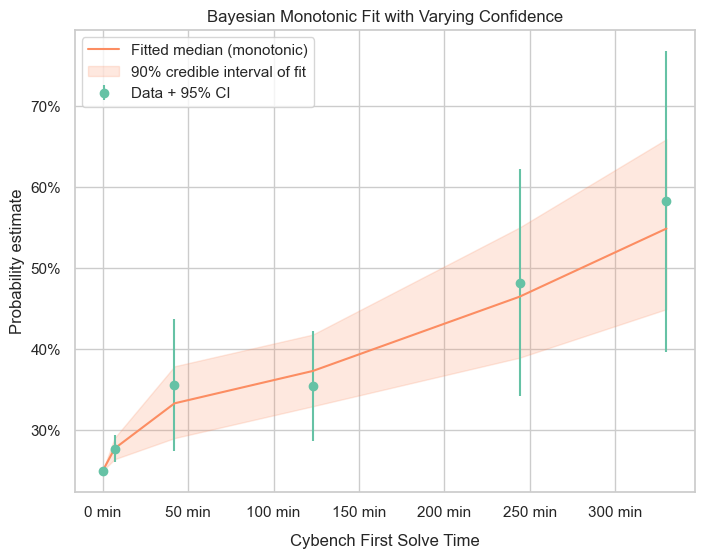

In [50]:
# # After sampling:
# with monotonic_model:
#     # Summaries of the posterior
#     az.plot_trace(trace)
#     plt.show()

#     print(az.summary(trace, var_names=["intercept", "increments", "f_vals"]))

# Posterior predictive: compute f_vals for each sample
f_samples = trace.posterior["f_vals"].values  # shape: (chain, draw, n_points)

# Let's visualize the median and credible interval for the fitted monotonic function
median_f = np.median(f_samples, axis=(0,1))   # median across all chains/draws
lower_f = np.percentile(f_samples, 5, axis=(0,1))
upper_f = np.percentile(f_samples, 95, axis=(0,1))

plt.figure(figsize=(8,6))


plt.errorbar(x, y, yerr=ci, fmt='o', label="Data + 95% CI")
plt.plot(x, median_f, label="Fitted median (monotonic)", color="C1")
plt.fill_between(x, lower_f, upper_f, alpha=0.2, color="C1",
                 label="90% credible interval of fit")

plt.xlabel("Cybench First Solve Time", labelpad=10)  # Added labelpad to move label down
plt.ylabel("Probability estimate")
plt.title("Bayesian Monotonic Fit with Varying Confidence")
plt.legend(loc='upper left')

# Format y-axis ticks to include % symbol
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x)}%"))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x)} min"))

plt.show()


C:\Users\papad\AppData\Local\Temp\ipykernel_20036\3678369334.py:25: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(-5, x[-1]+1)  # Set x-axis limits from first to last point


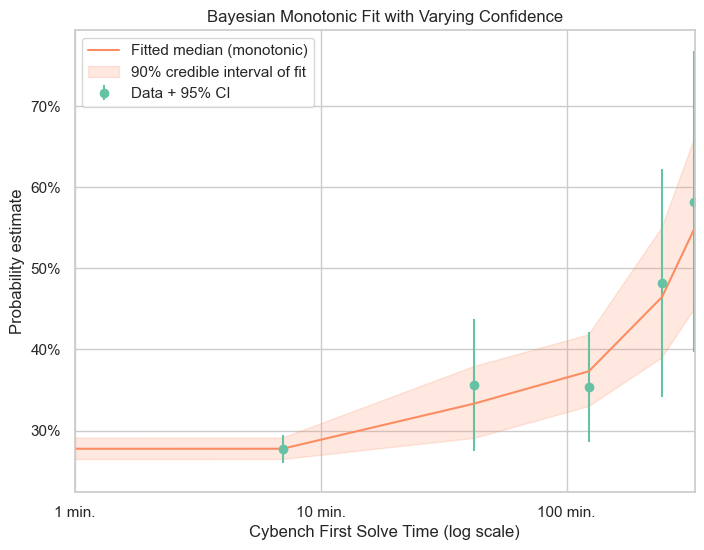

In [46]:
f_samples = trace.posterior["f_vals"].values  # shape: (chain, draw, n_points)

# Let's visualize the median and credible interval for the fitted monotonic function
median_f = np.median(f_samples, axis=(0,1))   # median across all chains/draws
lower_f = np.percentile(f_samples, 5, axis=(0,1))
upper_f = np.percentile(f_samples, 95, axis=(0,1))

plt.figure(figsize=(8,6))
plt.semilogx()  # Set x-axis to log scale
#plt.gca().xaxis.set_major_formatter(ScalarFormatter())

# Create custom ticks for log scale
ticks = []
# Add ticks for 10-100 range (every 10)
ticks.extend(range(10, 100, 10))
# Add ticks for 100-1000 range (every 100) 
ticks.extend(range(100, 500, 100))

plt.errorbar(x, y, yerr=ci, fmt='o', label="Data + 95% CI")
plt.plot(x, median_f, label="Fitted median (monotonic)", color="C1")
plt.fill_between(x, lower_f, upper_f, alpha=0.2, color="C1",
                 label="90% credible interval of fit")
plt.xticks(ticks)  # Set the custom ticks
plt.xticks([1, 10, 100], ["1 min.", "10 min.", "100 min."])
plt.xlim(-5, x[-1]+1)  # Set x-axis limits from first to last point
plt.xlabel("Cybench First Solve Time (log scale)")
plt.ylabel("Probability estimate")
plt.title("Bayesian Monotonic Fit with Varying Confidence")
plt.legend(loc='upper left')

# Format y-axis ticks to include % symbol
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x)}%"))

plt.show()

With benchmark percentile instead of FST:

In [7]:
# ---------------------------------
# 1) Prepare data
# ---------------------------------
x = np.array([0, 20, 40, 60, 80, 100]) #cybench percentile
y = np.array([25, 27.71, 35.57, 35.4, 48.2, 58.2]) 
ci = np.array([0.01, 1.68, 8.12, 6.77, 14.02, 18.55])  # half-width of 95% CI or similar

# For simplicity, let's approximate the standard deviation for each point.
# If ci is half-width of a 95% CI, then roughly:
#    95% CI = mean ± 1.96*sigma
# => half-width ~ 1.96*sigma
# => sigma ~ half-width / 1.96
sigma = ci / 1.96

# Ensure x is sorted. (It already is in this example.)
# If it weren't sorted, we'd sort x,y,sigma together.

# ---------------------------------
# 2) Define a PyMC model
# ---------------------------------
with pm.Model() as monotonic_model:
    # Intercept: f(x_0)
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    
    # We have (n-1) increments for n points. Each increment >= 0 (HalfNormal ensures positivity).
    increments = pm.HalfNormal("increments", sigma=10, shape=len(x)-1)
    
    # f_vals[i] = intercept + sum(increments[:i])
    # so f(x_0) = intercept
    #    f(x_1) = intercept + increments[0]
    #    f(x_2) = intercept + increments[0] + increments[1]
    # ... and so on ...
    f_vals = pm.Deterministic(
        "f_vals",
        intercept + pm.math.cumsum(pm.math.concatenate([[0], increments]))
    )
    
    # Likelihood: each observed y_i ~ Normal(f_vals[i], sigma[i])
    pm.Normal("obs", mu=f_vals, sigma=sigma, observed=y)
    
    # ---------------------------------
    # 3) Sample from the posterior
    # ---------------------------------
    trace = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=42)

[2, 4, 5, 6, 6, 7, 9, 9, 9, 11, 11, 20, 29, 32, 35, 42, 42, 43, 45, 51, 52, 60, 65, 75, 78, 84, 85, 105, 120, 123, 132, 133, 159, 204, 244, 330, 356, 368, 454, 1494]
0      7
1     42
2    123
3    244
4    330
Name: fst, dtype: int64


NameError: name 'pm' is not defined

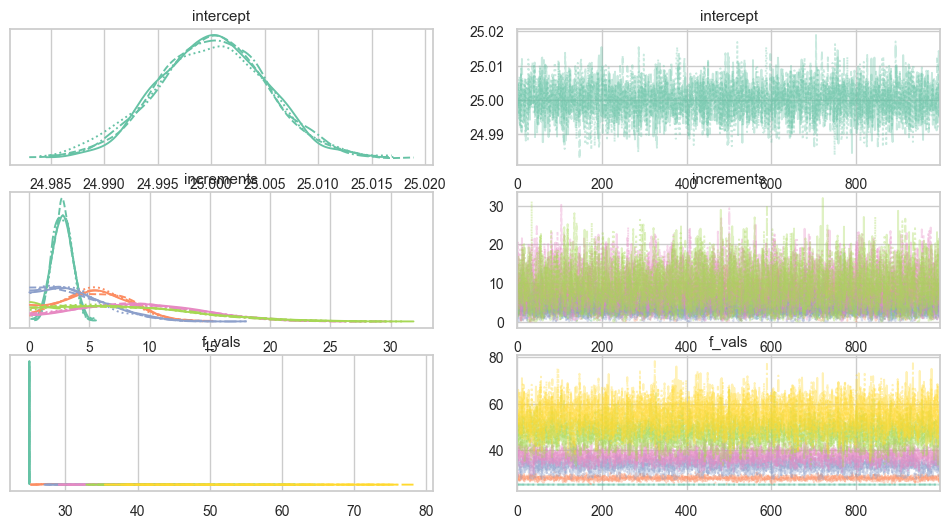

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept      25.000  0.005  24.990   25.009      0.000    0.000    3255.0   
increments[0]   2.750  0.812   1.277    4.289      0.018    0.012    2140.0   
increments[1]   5.603  2.777   0.302   10.122      0.072    0.051    1334.0   
increments[2]   3.999  2.768   0.004    8.954      0.061    0.043    1648.0   
increments[3]   9.314  4.973   0.159   17.695      0.102    0.072    1850.0   
increments[4]   8.400  5.534   0.002   18.001      0.115    0.081    1641.0   
f_vals[0]      25.000  0.005  24.990   25.009      0.000    0.000    3255.0   
f_vals[1]      27.750  0.812  26.288   29.300      0.018    0.012    2142.0   
f_vals[2]      33.352  2.708  28.481   38.280      0.066    0.047    1580.0   
f_vals[3]      37.352  2.679  32.216   42.170      0.045    0.032    3509.0   
f_vals[4]      46.666  4.854  37.329   55.283      0.089    0.063    2790.0   
f_vals[5]      55.066  6.351  43.543   66.958      0

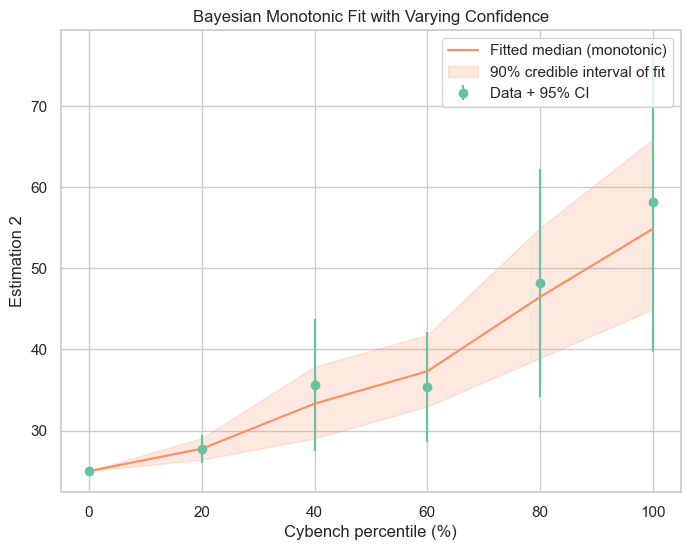

In [16]:
# After sampling:
with monotonic_model:
    # Summaries of the posterior
    az.plot_trace(trace)
    plt.show()

    print(az.summary(trace, var_names=["intercept", "increments", "f_vals"]))

# Posterior predictive: compute f_vals for each sample
f_samples = trace.posterior["f_vals"].values  # shape: (chain, draw, n_points)

# Let's visualize the median and credible interval for the fitted monotonic function
median_f = np.median(f_samples, axis=(0,1))   # median across all chains/draws
lower_f = np.percentile(f_samples, 5, axis=(0,1))
upper_f = np.percentile(f_samples, 95, axis=(0,1))

plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr=ci, fmt='o', label="Data + 95% CI")
plt.plot(x, median_f, label="Fitted median (monotonic)", color="C1")
plt.fill_between(x, lower_f, upper_f, alpha=0.2, color="C1",
                 label="90% credible interval of fit")
plt.xlabel("Cybench percentile (%)")
plt.ylabel("Estimation 2")
plt.title("Bayesian Monotonic Fit with Varying Confidence")
plt.legend()
plt.show()


In [12]:
benchmark_fst = [2,4,6,6,7,9,11,20,42,43,65,75,78,120,123,132,368,5,9,9,29,45,51,84,133,159,11,35,42,85,105,244,330,356,60,204,454,1494,32,52]
#sort the list
benchmark_fst.sort()

# Create array of indices for each value in fst['fst'].values
indices = np.array([benchmark_fst.index(x)/40*100 for x in fst['fst'].values])

print("Benchmark FST values:", benchmark_fst)
print("Length of benchmark FST:", len(benchmark_fst))
print("FST values:", fst['fst'].values)
print("Indices of FST values in benchmark:", indices)
# Add a 0 at the beginning and convert to a numpy array
indices = np.insert(indices, 0, 0)
indices = np.array(indices)

print(indices)

# ---------------------------------
# 1) Prepare data
# ---------------------------------
x = indices
y = np.array([25, 27.71, 35.57, 35.4, 48.2, 58.2]) 
ci = np.array([0.01, 1.68, 8.12, 6.77, 14.02, 18.55])  # half-width of 95% CI or similar

# For simplicity, let's approximate the standard deviation for each point.
# If ci is half-width of a 95% CI, then roughly:
#    95% CI = mean ± 1.96*sigma
# => half-width ~ 1.96*sigma
# => sigma ~ half-width / 1.96
sigma = ci / 1.96

# Ensure x is sorted. (It already is in this example.)
# If it weren't sorted, we'd sort x,y,sigma together.

# ---------------------------------
# 2) Define a PyMC model
# ---------------------------------
with pm.Model() as monotonic_model:
    # Intercept: f(x_0)
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    
    # We have (n-1) increments for n points. Each increment >= 0 (HalfNormal ensures positivity).
    increments = pm.HalfNormal("increments", sigma=10, shape=len(x)-1)
    
    # f_vals[i] = intercept + sum(increments[:i])
    # so f(x_0) = intercept
    #    f(x_1) = intercept + increments[0]
    #    f(x_2) = intercept + increments[0] + increments[1]
    # ... and so on ...
    f_vals = pm.Deterministic(
        "f_vals",
        intercept + pm.math.cumsum(pm.math.concatenate([[0], increments]))
    )
    
    # Likelihood: each observed y_i ~ Normal(f_vals[i], sigma[i])
    pm.Normal("obs", mu=f_vals, sigma=sigma, observed=y)
    
    # ---------------------------------
    # 3) Sample from the posterior
    # ---------------------------------
    trace = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=42)

Benchmark FST values: [2, 4, 5, 6, 6, 7, 9, 9, 9, 11, 11, 20, 29, 32, 35, 42, 42, 43, 45, 51, 52, 60, 65, 75, 78, 84, 85, 105, 120, 123, 132, 133, 159, 204, 244, 330, 356, 368, 454, 1494]
Length of benchmark FST: 40
FST values: [  7  42 123 244 330]
Indices of FST values in benchmark: [12.5 37.5 72.5 85.  87.5]
[ 0.  12.5 37.5 72.5 85.  87.5]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, increments]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 160 seconds.


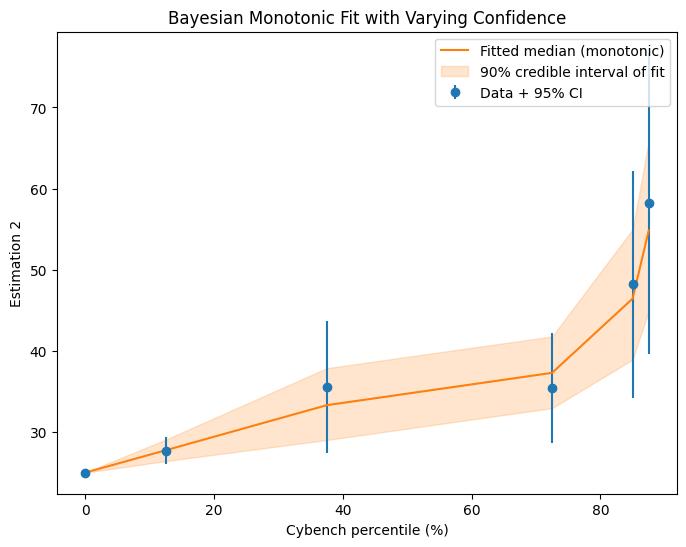

In [14]:


# Posterior predictive: compute f_vals for each sample
f_samples = trace.posterior["f_vals"].values  # shape: (chain, draw, n_points)

# Create extended x range up to 100
x_extended = np.concatenate([x, [100]])

# For each posterior sample, linearly extrapolate to x=100
# Using the last increment to project the final segment
last_increments = f_samples[:,:,-1] - f_samples[:,:,-2]  # Get last slope for each sample
extra_increment = last_increments * (100 - x[-1])/(x[-1] - x[-2])  # Scale by x distance
f_samples_extended = np.concatenate([f_samples, 
                                   f_samples[:,:,-1:] + extra_increment[:,:,None]], axis=2)

# Calculate statistics on extended samples
median_f = np.median(f_samples_extended, axis=(0,1))
lower_f = np.percentile(f_samples_extended, 5, axis=(0,1))
upper_f = np.percentile(f_samples_extended, 95, axis=(0,1))

plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr=ci, fmt='o', label="Data + 95% CI")
plt.plot(x_extended, median_f, label="Fitted median (monotonic)", color="C1")
plt.fill_between(x_extended, lower_f, upper_f, alpha=0.2, color="C1",
                 label="90% credible interval of fit")
plt.xlabel("Cybench percentile (%)")
plt.ylabel("Estimation 2")
plt.title("Bayesian Monotonic Fit with Varying Confidence")
plt.legend()
plt.show()


[  0.   12.5  37.5  72.5  85.   87.5 100. ]
28000


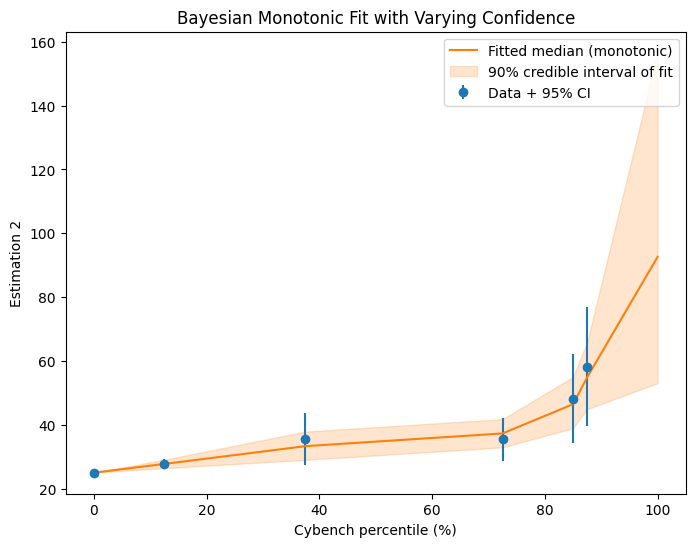

In [23]:
f_samples = trace.posterior["f_vals"].values  # shape: (chain, draw, n_points)

# Create extended x range up to 100
x_extended = np.concatenate([x, [100]])

print(x_extended)

# For each posterior sample, linearly extrapolate to x=100
# Using the last increment to project the final segment
last_increments = f_samples[:,:,-1] - f_samples[:,:,-2]  # Get last slope for each sample
extra_increment = last_increments * (100 - x[-1])/(x[-1] - x[-2])  # Scale by x distance
f_samples_extended = np.concatenate([f_samples, 
                                   f_samples[:,:,-1:] + extra_increment[:,:,None]], axis=2)
print(f_samples_extended.size)

# Calculate statistics on extended samples
median_f = np.median(f_samples_extended, axis=(0,1))
lower_f = np.percentile(f_samples_extended, 5, axis=(0,1))
upper_f = np.percentile(f_samples_extended, 95, axis=(0,1))

plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr=ci, fmt='o', label="Data + 95% CI")
plt.plot(x_extended, median_f, label="Fitted median (monotonic)", color="C1")
plt.fill_between(x_extended, lower_f, upper_f, alpha=0.2, color="C1",
                 label="90% credible interval of fit")
plt.xlabel("Cybench percentile (%)")
plt.ylabel("Estimation 2")
plt.title("Bayesian Monotonic Fit with Varying Confidence")
plt.legend()
plt.show()

In [ ]:
benchmark_fst = [2,4,6,6,7,9,11,20,42,43,65,75,78,120,123,132,368,5,9,9,29,45,51,84,133,159,11,35,42,85,105,244,330,356,60,204,454,1494,32,52]
#sort the list
benchmark_fst.sort()
print(benchmark_fst)
#get the fst value that LLM are succeeding at based on the percentage of task succeeded from this paper: https://cdn.prod.website-files.com/663bd486c5e4c81588db7a1d/6763fac97cd22a9484ac3c37_o1_uk_us_december_publication_final.pdf
model_score = {
    "O1": benchmark_fst[int(0.345*40)+1],
    "Sonnet 3.5 (new)": benchmark_fst[int(0.298*40)+1], 
    "o1-preview": benchmark_fst[int(0.258*40)+1],
    "Sonnet 3.5 (old)": benchmark_fst[int(0.262*40)+1],
    "GPT4o": benchmark_fst[int(0.210*40)+1]
}

# Suppose you already have:
# x           # Your x-values
# median_f    # The median fitted values for each x
# model_score # Dictionary of model -> fst_value

# 1) For convenience, build an interpolator over (x, median_f).
#    If x is strictly increasing, we can use np.interp directly:
def get_median_y(fst):
    """
    Given an fst value, returns the interpolated median_f on your discrete grid.
    """
    return np.interp(fst, x, median_f)

sns.set_theme(style="whitegrid", palette="Set2")
f_samples = trace.posterior["f_vals"].values  # shape: (chain, draw, n_points)

# Let's visualize the median and credible interval for the fitted monotonic function
median_f = np.median(f_samples, axis=(0,1))   # median across all chains/draws
lower_f = np.percentile(f_samples, 5, axis=(0,1))
upper_f = np.percentile(f_samples, 95, axis=(0,1))

plt.figure(figsize=(8,6))


plt.errorbar(x, y, yerr=ci, fmt='o', label="Data + 95% CI")
plt.plot(x, median_f, label="Fitted median (monotonic)", color="C1")
plt.fill_between(x, lower_f, upper_f, alpha=0.2, color="C1",
                 label="90% credible interval of fit")

plt.ylim(20, 70)  # Set x-axis limit from 0 to 500 minutes

plt.xlabel("Cybench First Solve Time", labelpad=10)  # Added labelpad to move label down
plt.ylabel("Probability Estimate")
plt.title("Interpolated Mapping Between Cybench First Solve Time and Probability Estimate")
plt.legend(loc='upper left')

# Format y-axis ticks to include % symbol
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x)}%"))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x)} min"))

# 3) Sort the model_score by FST so we can handle them in ascending order
sorted_models = sorted(model_score.items(), key=lambda kv: kv[1])

# 4) Draw dotted lines for each model, offsetting labels to prevent overlap
label_count = 0
vertical_offset = (max(median_f) - min(median_f)) * 0.03  # step in y-units
for model_name, fst_value in sorted_models:
    y_value = get_median_y(fst_value)
    
    # Vertical dotted line
    plt.plot([fst_value, fst_value], [0, y_value], linestyle='--', color='gray')
    # Horizontal dotted line
    plt.plot([0, fst_value], [y_value, y_value], linestyle='--', color='gray')
    
    # Plot the intersection dot
    plt.plot(fst_value, y_value, 'o', color='black')
    
    # Text label with incremental vertical offset
    offset = label_count * vertical_offset - 5
    plt.text(
        fst_value, 
        y_value + offset,  # small vertical shift
        f"{model_name}",
        va='bottom', 
        ha='left',
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8)
    )
    label_count += 1
# Save and show
plt.show()

#save the plot
#plt.savefig("interpolation_vizualisation_with models.png", dpi=300)


plt.show()